In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from collections import Counter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from IPython import get_ipython
from IPython.display import display

In [2]:
# Charger le jeu de données
df=pd.read_csv("eng.train", sep=" ")
df.head()

,-DOCSTART-,-X-,-X-.1,O
0,EU,NNP,B-NP,B-ORG
1,rejects,VBZ,B-VP,O
2,German,JJ,B-NP,B-MISC
3,call,NN,I-NP,O
4,to,TO,B-VP,O


In [3]:
# Fonction pour charger un jeu de données au format CoNLL
def load_conll_dataset(file_path):
    """
    Charge un jeu de données au format CoNLL à partir d'un fichier.

    Args:
        file_path (str): Le chemin d'accès au fichier du jeu de données.

    Returns:
        tuple: Un tuple contenant deux listes :
            - sentences: Une liste de phrases, où chaque phrase est une liste de mots.
            - tags: Une liste de séquences d'étiquettes, où chaque séquence d'étiquettes correspond à une phrase.
    """
    sentences, tags = [], []  # Initialisation des listes pour les phrases et les étiquettes
    current_sentence, current_tags = [], []  # Initialisation des listes pour la phrase et les étiquettes courantes

    # Ouvrir le fichier en mode lecture ('r')
    with open(file_path, 'r') as file:
        # Parcourir chaque ligne du fichier
        for line in file:
            line = line.strip()  # Supprimer les espaces blancs au début et à la fin de la ligne

            # Si la ligne est vide, cela indique la fin d'une phrase
            if not line:
                # Si la phrase courante n'est pas vide, l'ajouter aux listes sentences et tags
                if current_sentence:
                    sentences.append(current_sentence)
                    tags.append(current_tags)
                    current_sentence, current_tags = [], []  # Réinitialiser les listes pour la phrase et les étiquettes courantes
            # Sinon, la ligne contient un mot et son étiquette
            else:
                # Diviser la ligne en mot et étiquette en utilisant l'espace comme séparateur
                word, tag = line.split()[0], line.split()[-1]
                # Ajouter le mot et l'étiquette aux listes courantes
                current_sentence.append(word)
                current_tags.append(tag)

        # Si la dernière phrase n'a pas été ajoutée, l'ajouter aux listes sentences et tags
        if current_sentence:
            sentences.append(current_sentence)
            tags.append(current_tags)

    # Retourner les listes sentences et tags
    return sentences, tags

In [4]:
# Importer le module Counter pour compter les occurrences
from collections import Counter

# Définir une fonction pour créer le vocabulaire et les ensembles d'étiquettes
def create_vocab_and_tags(sentences, tags):
    """
    Crée le vocabulaire, les mappages mot-index, étiquette-index et index-étiquette.

    Args:
        sentences (list): Liste de phrases (listes de mots).
        tags (list): Liste de séquences d'étiquettes (listes d'étiquettes).

    Returns:
        tuple: Un tuple contenant trois dictionnaires :
            - word_to_idx: Mappage des mots à leurs index.
            - tag_to_idx: Mappage des étiquettes à leurs index.
            - idx_to_tag: Mappage des index à leurs étiquettes.
    """
    # Compter les occurrences de chaque mot dans toutes les phrases
    word_counter = Counter(word for sentence in sentences for word in sentence)
    # Créer un ensemble unique d'étiquettes
    tag_set = set(tag for tag_seq in tags for tag in tag_seq)

    # Créer un mappage mot-index, en commençant par 2 pour réserver 0 et 1 pour <PAD> et <UNK>
    word_to_idx = {word: idx + 2 for idx, word in enumerate(word_counter.keys())}
    word_to_idx["<PAD>"] = 0  # Index pour le padding (rembourrage)
    word_to_idx["<UNK>"] = 1  # Index pour les mots inconnus

    # Créer un mappage étiquette-index et index-étiquette
    tag_to_idx = {tag: idx for idx, tag in enumerate(tag_set)}
    idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

    # Retourner les trois dictionnaires
    return word_to_idx, tag_to_idx, idx_to_tag

sentences, tags = load_conll_dataset("eng.train")  # Charger le jeu de données
# Appeler la fonction pour créer les dictionnaires de vocabulaire et d'étiquettes
word_to_idx, tag_to_idx, idx_to_tag = create_vocab_and_tags(sentences, tags)

In [5]:
# Convertir les mots et les étiquettes en indices et appliquer le padding aux séquences
def prepare_data(sentences, tags, word_to_idx, tag_to_idx, max_len=50):
    """
    Prépare les données pour l'entraînement du modèle.

    Convertit les mots et les étiquettes en indices numériques
    et applique le padding aux séquences pour qu'elles aient toutes la même longueur.

    """
    # Convertir les mots en indices, en utilisant l'index de <UNK> pour les mots inconnus
    X = [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence] for sentence in sentences]
    # Convertir les étiquettes en indices
    y = [[tag_to_idx[tag] for tag in tag_seq] for tag_seq in tags]

    # Appliquer le padding aux séquences de mots et d'étiquettes
    X = pad_sequences(X, maxlen=max_len, padding="post", value=word_to_idx["<PAD>"])
    y = pad_sequences(y, maxlen=max_len, padding="post", value=tag_to_idx["O"])
    # Encoder les étiquettes en one-hot
    y = [to_categorical(seq, num_classes=len(tag_to_idx)) for seq in y]

    # Retourner les tableaux NumPy
    return np.array(X), np.array(y)

# Diviser les données en ensembles d'entraînement et de test
max_len = 50  # Longueur maximale des séquences
X, y = prepare_data(sentences, tags, word_to_idx, tag_to_idx, max_len)  # Préparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Diviser les données

c:\Users\Mohamed\Desktop\INDIA S3\Deep Learning\NER project\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 100)        │     2,362,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 9)          │         2,313 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,409 (9.92 MB)

 Trainable params: 2,599,409 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

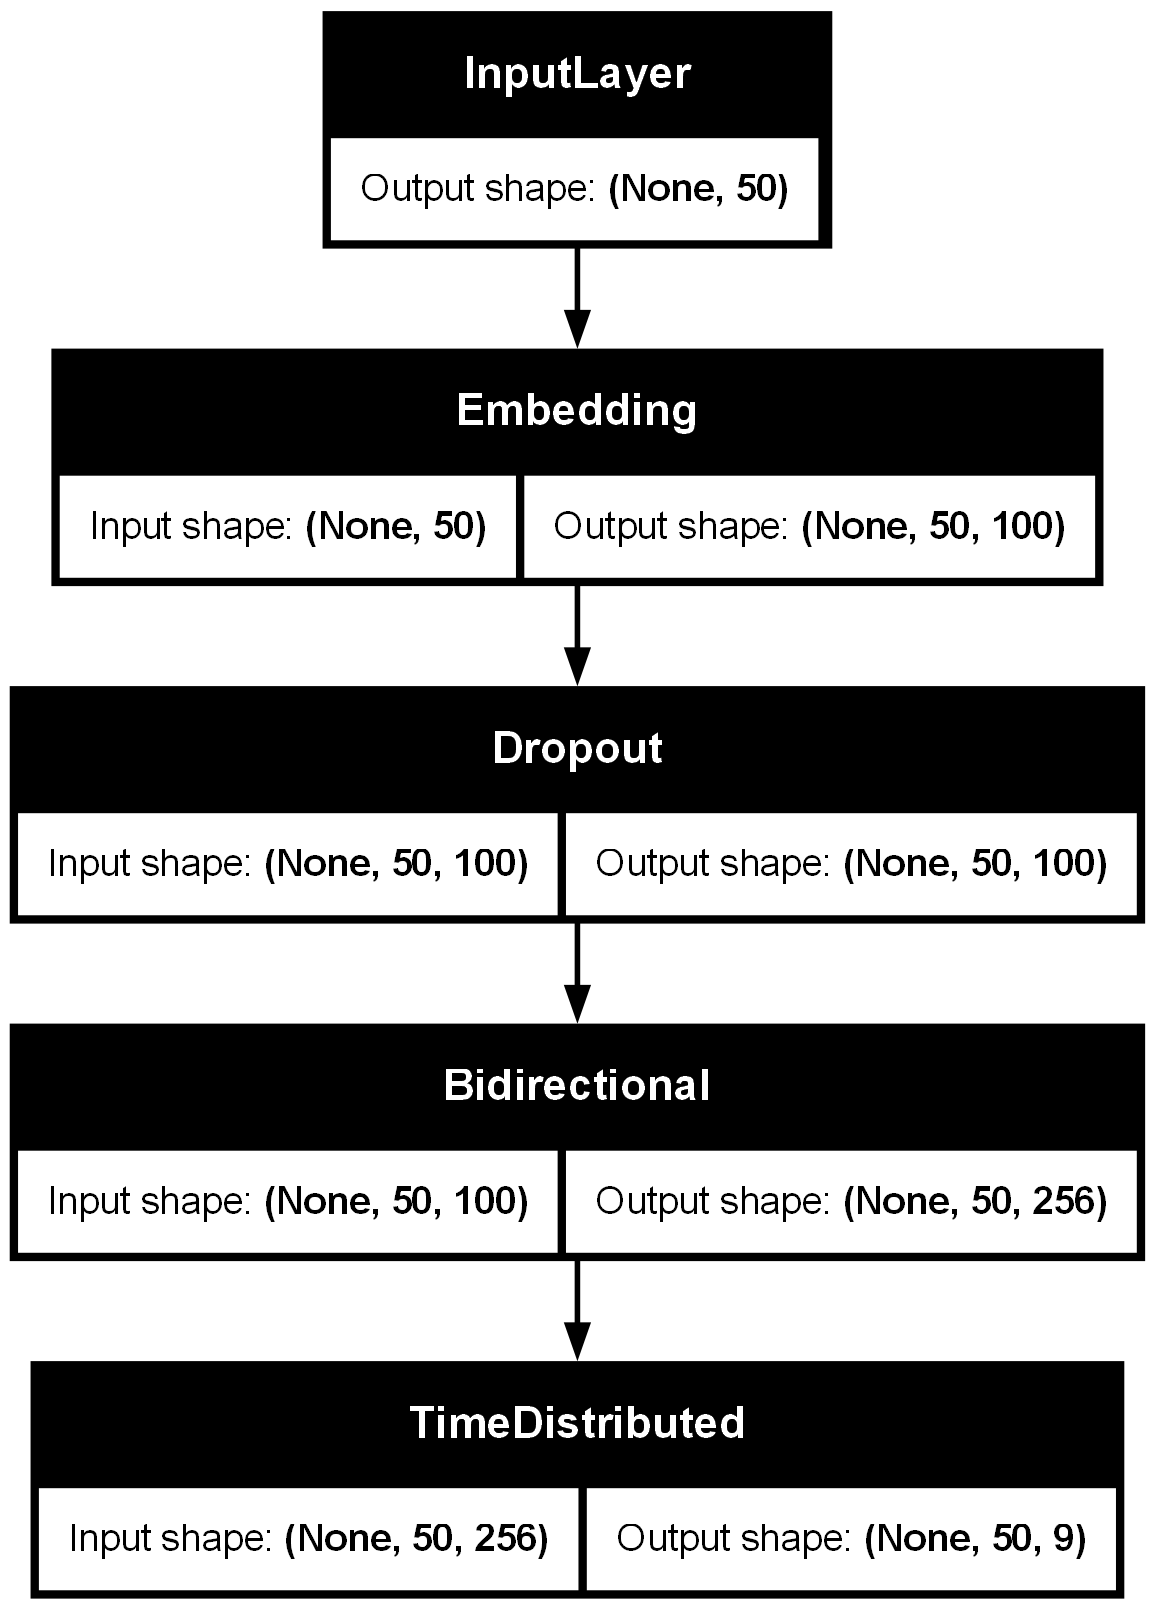

In [6]:
# Définir la fonction pour construire le modèle
def build_model(vocab_size, tag_size, embedding_dim=100, hidden_units=128, max_len=50):

    # Définir la couche d'entrée
    input = Input(shape=(max_len,))
    # Couche d'embedding pour représenter les mots en vecteurs
    model = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input)
    # Couche de dropout pour éviter le surapprentissage
    model = Dropout(0.1)(model)
    # Couche LSTM bidirectionnelle pour capturer les dépendances contextuelles
    model = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model)
    # Couche Dense pour la classification des étiquettes pour chaque mot
    out = TimeDistributed(Dense(tag_size, activation="softmax"))(model)

    # Créer le modèle Keras
    model = Model(input, out)
    # Compiler le modèle avec l'optimiseur Adam, la fonction de perte categorical_crossentropy et la métrique accuracy
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # Retourner le modèle compilé
    return model

# Créer une instance du modèle
model = build_model(vocab_size=len(word_to_idx), tag_size=len(tag_to_idx), max_len=max_len)
# Afficher un résumé du modèle
model.summary()
plot_model(model,show_shapes=True)

In [7]:
# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    batch_size=32,  # Taille des lots (batch size)
    epochs=5,  # Nombre d'époques d'entraînement
    validation_split=0.2  # Proportion des données d'entraînement à utiliser pour la validation
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.9354 - loss: 0.3339 - val_accuracy: 0.9660 - val_loss: 0.1046
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.9735 - loss: 0.0813 - val_accuracy: 0.9822 - val_loss: 0.0596
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9893 - loss: 0.0375 - val_accuracy: 0.9891 - val_loss: 0.0410
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - accuracy: 0.9964 - loss: 0.0157 - val_accuracy: 0.9904 - val_loss: 0.0352
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.9981 - loss: 0.0085 - val_accuracy: 0.9908 - val_loss: 0.0338


In [8]:
# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)  # Évaluer le modèle sur les données de test
print(f"Test Loss: {test_loss:.4f}")  # Afficher la perte sur les données de test
print(f"Test Accuracy: {test_accuracy:.4f}")  # Afficher la précision sur les données de test

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)  # Obtenir les prédictions du modèle
y_pred = np.argmax(y_pred, axis=-1)  # Convertir les prédictions en indices d'étiquettes
y_true = np.argmax(y_test, axis=-1)  # Convertir les vraies étiquettes en indices d'étiquettes

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9900 - loss: 0.0373
Test Loss: 0.0350
Test Accuracy: 0.9906
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


In [9]:
# Décoder les prédictions
def decode_predictions(y_indices, idx_to_tag):
    """Convertit les indices en étiquettes, en excluant les indices de padding."""
    decoded = []
    for seq in y_indices:
        decoded_seq = [idx_to_tag[idx] for idx in seq if idx != 0]  # Ignore l'index de padding (0)
        decoded.append(decoded_seq)
    return decoded

# Décoder les prédictions et les vraies étiquettes
y_pred_tags = decode_predictions(y_pred, idx_to_tag)
y_true_tags = decode_predictions(y_true, idx_to_tag)

# Aligner les longueurs pour l'évaluation
aligned_y_true = []
aligned_y_pred = []

for true_seq, pred_seq in zip(y_true_tags, y_pred_tags):
    min_len = min(len(true_seq), len(pred_seq))
    aligned_y_true.extend(true_seq[:min_len])
    aligned_y_pred.extend(pred_seq[:min_len])

# Évaluer en utilisant le rapport de classification
print(classification_report(aligned_y_true, aligned_y_pred))  # Afficher le rapport de classification

              precision    recall  f1-score   support

       B-LOC       0.92      0.83      0.88      1412
       B-ORG       0.87      0.82      0.85      1216
       B-PER       0.88      0.85      0.87      1386
       I-LOC       0.82      0.67      0.73       237
      I-MISC       0.64      0.70      0.67       264
       I-ORG       0.80      0.78      0.79       716
       I-PER       0.90      0.81      0.85       961
           O       0.99      1.00      1.00    142927

    accuracy                           0.99    149119
   macro avg       0.85      0.81      0.83    149119
weighted avg       0.99      0.99      0.99    149119



In [10]:
idx_to_tag

{0: 'B-MISC',
 1: 'I-PER',
 2: 'I-LOC',
 3: 'O',
 4: 'B-LOC',
 5: 'I-MISC',
 6: 'B-ORG',
 7: 'B-PER',
 8: 'I-ORG'}

In [11]:
tag_names = {
      0: 'Miscellaneous' ,
      1: 'Person',
      2: 'Location' ,
      3: 'Other' ,
      4: 'Location' ,
      5: 'Miscellaneous' ,
      6: 'Organization',
      7: 'Person',
      8: 'Organization'
    }

In [20]:
# Définir une fonction pour tester le modèle sur une phrase personnalisée
def test_sentence(sentence, model, word_to_idx, idx_to_tag, max_len=50):
    """
    Teste le modèle NER sur une phrase donnée.

    Args:
        sentence (str): La phrase d'entrée.
        model (keras.Model): Le modèle NER entraîné.
        word_to_idx (dict): Mappage des mots à leurs indices.
        idx_to_tag (dict): Mappage des indices à leurs étiquettes.
        max_len (int): Longueur maximale de la séquence pour le padding.

    Returns:
        list: Liste de tuples, chaque tuple contenant un mot et son étiquette prédite.
    """
    # Tokeniser la phrase
    tokens = sentence.split()

    # Convertir les tokens en indices
    token_indices = [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in tokens]

    # Appliquer le padding à la séquence
    token_indices_padded = pad_sequences([token_indices], maxlen=max_len, padding="post", value=word_to_idx["<PAD>"])

    # Faire des prédictions
    predictions = model.predict(token_indices_padded)
    predicted_indices = np.argmax(predictions, axis=-1)[0]  # Obtenir les indices des étiquettes les plus probables

    # Décoder les prédictions
    #predicted_tags = [idx_to_tag[idx] for idx in predicted_indices[:len(tokens)]]

    predicted_tags = [tag_names[idx] for idx in predicted_indices[:len(tokens)]]


    # Associer les mots à leurs étiquettes
    return list(zip(tokens, predicted_tags))

# Exemple d'utilisation
custom_sentence = "Google and Microsoft are competing in the AI market."  # Phrase à tester
predictions = test_sentence(custom_sentence, model, word_to_idx, tag_names)  # Appeler la fonction de test

# Afficher les résultats
for word, tag in predictions:  # Parcourir les prédictions
    print(f"{word:15} {tag}")  # Afficher le mot et son étiquette

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Google          Other
and             Other
Microsoft       Organization
are             Other
competing       Other
in              Other
the             Other
AI              Miscellaneous
market.         Miscellaneous


In [13]:
def display_ner_predictions(sentence, predictions, tag_names):
    """
    Displays NER predictions in a user-friendly format.

    Args:
        sentence: The input sentence.
        predictions: A list of (word, tag_id) tuples.
        tag_mapping: A dictionary mapping tag IDs to readable tag names.
    """

    entities = []
    current_entity = []
    for word, tag in predictions:

        if tag != "Other":  # Beginning of a new entity or inside an existing one
            if not current_entity or current_entity[0][1] == tag:
                current_entity.append((word, tag))
            else: # Different entity type
                entities.append((" ".join([w for w, _ in current_entity]), current_entity[0][1]))
                current_entity = [(word, tag)]
        else:  # Outside any entity (O tag)
            if current_entity:
                entities.append((" ".join([w for w, _ in current_entity]), current_entity[0][1]))
            current_entity = []

    if current_entity:
        entities.append((" ".join([w for w, _ in current_entity]), current_entity[0][1]))

    result = {}
    if entities:
        print("Entities:")
        for entity_text, entity_type in entities:
            result[entity_text] = entity_type
            print(f"- {entity_text} ({entity_type})")
    else:
        print("No entities found.")

    return result

In [14]:
result = display_ner_predictions(custom_sentence, predictions, tag_names)

Entities:
- Microsoft (Organization)
- AI market. (Miscellaneous)


In [15]:
print(result)

{'Microsoft': 'Organization', 'AI market.': 'Miscellaneous'}


In [17]:
# Sauvegarder le modèle
model.save('ner_model_2.keras')

In [19]:
import json

# Serialize the word2id dictionary to a JSON file
with open('word_to_idx.json', 'w') as f:
    json.dump(word_to_idx, f)

